In [1]:
import os
import time
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

feature_limit = 275

brain_list = []
typelist = ['glioma', 'meningioma', 'pituitary', 'notumor']
for x in typelist:
    for image in os.listdir(f"/Users/richardsoong/Downloads/brain-tumor-mri-dataset/{x}")[:feature_limit]:
        image_path = os.path.join(f"/Users/richardsoong/Downloads/brain-tumor-mri-dataset/{x}", image)
        img_arr = np.array(Image.open(image_path).resize((64,64)))
        if len(img_arr.shape) == 3:
            img_arr = img_arr[:, :, 0]
    
        #print(img_arr.shape)
        #plt.imshow(img_arr)
        #plt.show()
        brain_list.append(img_arr.flatten())

x = np.array(brain_list) / 255



/Users/richardsoong/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#create label arrays:
gli = np.ones((feature_limit, 1))
men = np.ones((feature_limit, 1))
pit = np.ones((feature_limit, 1))
notu = np.zeros((feature_limit, 1))

# two categories (Cancer or not) Using MLP Classifier
y = np.vstack((gli, men, pit, notu))
#y = np.vstack((gli, men*2, pit*3, notu))[:, 0]

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2)
#print(x)


In [3]:
perceptron = MLPClassifier(hidden_layer_sizes=(64, 30), learning_rate='invscaling')
perceptron.fit(xtrain, ytrain.flatten())
perceptron_pred = perceptron.predict(xtest)
acc_perceptron = accuracy_score(ytest.flatten(), perceptron_pred)
f1_perceptron = f1_score(ytest, perceptron_pred)
print('perceptron acc/f1')
print(acc_perceptron)
print(f1_perceptron)


adaboost = AdaBoostClassifier(n_estimators=100, random_state=12)
adaboost.fit(xtrain, ytrain.flatten())
ada_pred = adaboost.predict(xtest)
acc_adaboost = accuracy_score(ytest.flatten(), ada_pred)
f1_adaboost = f1_score(ytest, ada_pred)
print('adaboost acc/f1')
print(acc_adaboost)
print(f1_adaboost)



perceptron acc/f1
0.9409090909090909
0.9611940298507463
adaboost acc/f1
0.9545454545454546
0.9696969696969697


In [4]:
NB = GaussianNB(var_smoothing = (1/1000))
NB.fit(xtrain, ytrain.flatten())
NB_pred = NB.predict(xtest)
acc_NB = accuracy_score(ytest, NB_pred)
f1_NB = f1_score(ytest, NB_pred)
print('Naive bayes acc/f1')
print(acc_NB)
print(f1_NB)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(xtrain, ytrain)
knn_pred = knn.predict(xtest)
acc_knn = accuracy_score(ytest, knn_pred)
f1_knn = f1_score(ytest, knn_pred)
print('KNN acc/f1')
print(acc_knn)
print(f1_knn)

Naive bayes acc/f1
0.9045454545454545
0.9376854599406528
KNN acc/f1
0.9363636363636364
0.9573170731707317


/Users/richardsoong/Library/Python/3.9/lib/python/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [5]:
modelresults = {'Perceptron': {'accuracy':acc_perceptron, 'f1':f1_perceptron}, 'Adaboost': {'accuracy':acc_adaboost, 'f1':f1_adaboost}, 
                 'Naive Bayes': {'accuracy':acc_NB, 'f1':f1_NB}, 'KNN': {'accuracy':acc_knn, 'f1':f1_knn}}

display(pd.DataFrame(modelresults))

,Perceptron,Adaboost,Naive Bayes,KNN
accuracy,0.940909,0.954545,0.904545,0.936364
f1,0.961194,0.969697,0.937685,0.957317


In [6]:
# 4 categories (glioma, meningioma, pituitary, notumor)
y = np.vstack((gli, men*2, pit*3, notu))[:, 0]
#y = y.reshape((1200, 1))


In [7]:
#x = x / 255
x = x.reshape(-1, 64, 64, 1)
#print(x.shape)

In [8]:
# Split data in training / testing sets

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2)

In [9]:
# 4 classes
model2 = Sequential([
    Input(shape=(64, 64, 1)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'), 
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  
])

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Stop if val_loss doesn't improve for 3 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model2.fit(xtrain, ytrain, epochs=20, batch_size=32, validation_data=(xtest, ytest), callbacks=[early_stop])

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3147 - loss: 1.3265 - val_accuracy: 0.4591 - val_loss: 1.0892
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5655 - loss: 1.0171 - val_accuracy: 0.6909 - val_loss: 0.7946
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6678 - loss: 0.8200 - val_accuracy: 0.7364 - val_loss: 0.7014
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7495 - loss: 0.6528 - val_accuracy: 0.7045 - val_loss: 0.6287
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7648 - loss: 0.6049 - val_accuracy: 0.7500 - val_loss: 0.5653
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8144 - loss: 0.4645 - val_accuracy: 0.8273 - val_loss: 0.4552
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8526 - loss: 0.4341 - val_accuracy: 0.7773 - val_loss: 0.5836
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8411 - loss: 0.4235 - val_accuracy: 0.8227 - v

In [11]:
loss, accuracy = model2.evaluate(xtest, ytest)
print(f"Test accuracy: {accuracy:.4f}")

y_pred = model2.predict(xtest)
y_pred = np.argmax(y_pred, axis=1)
ytest = ytest.astype('int')
cnn_acc = accuracy_score(ytest, y_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8001 - loss: 0.4540 
Test accuracy: 0.8227
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


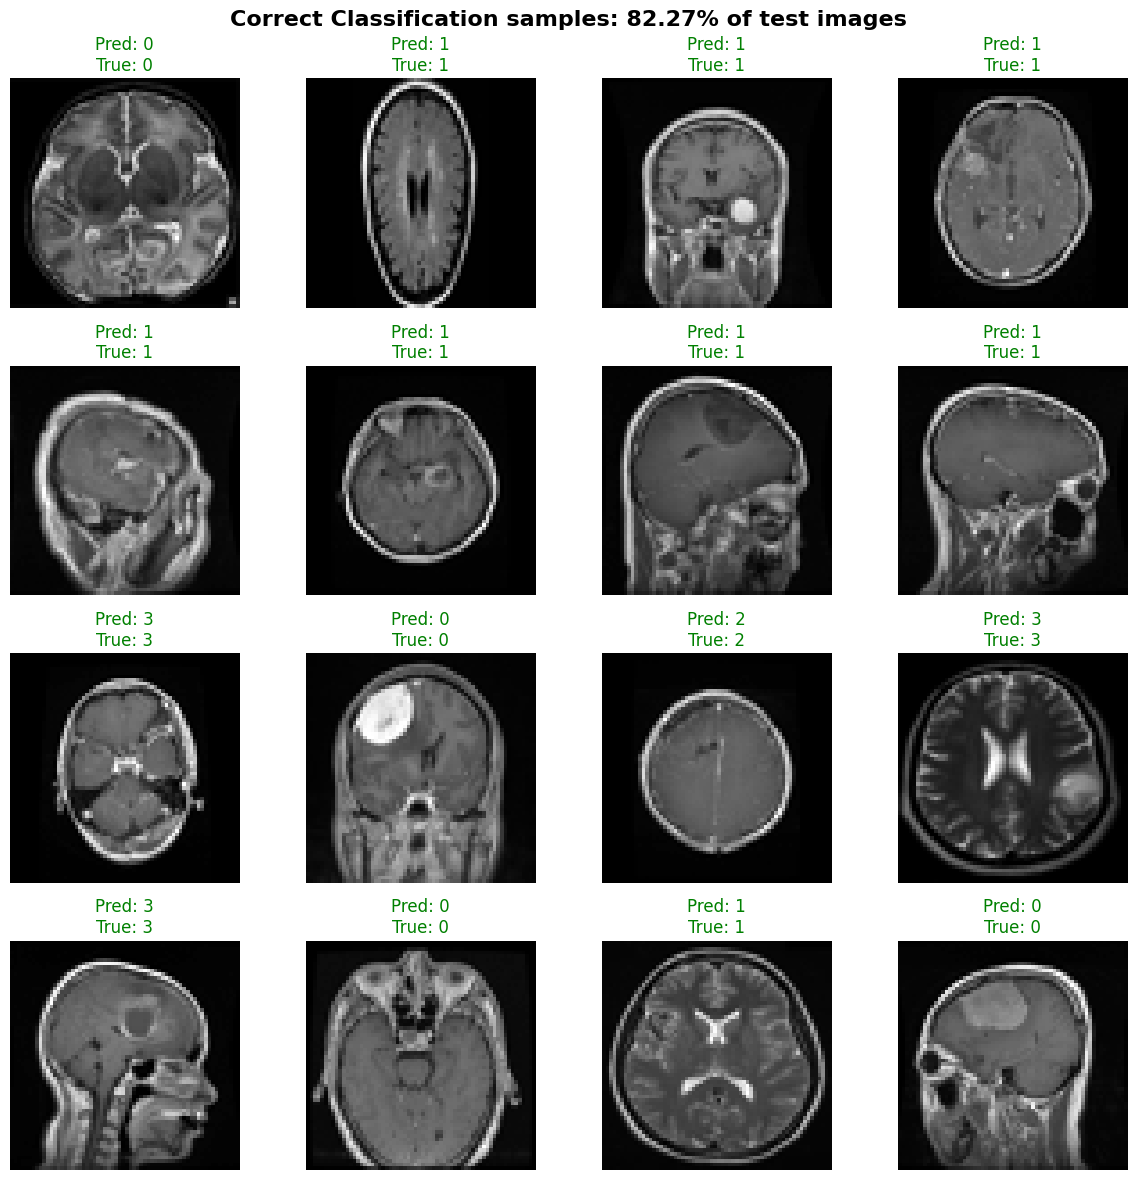

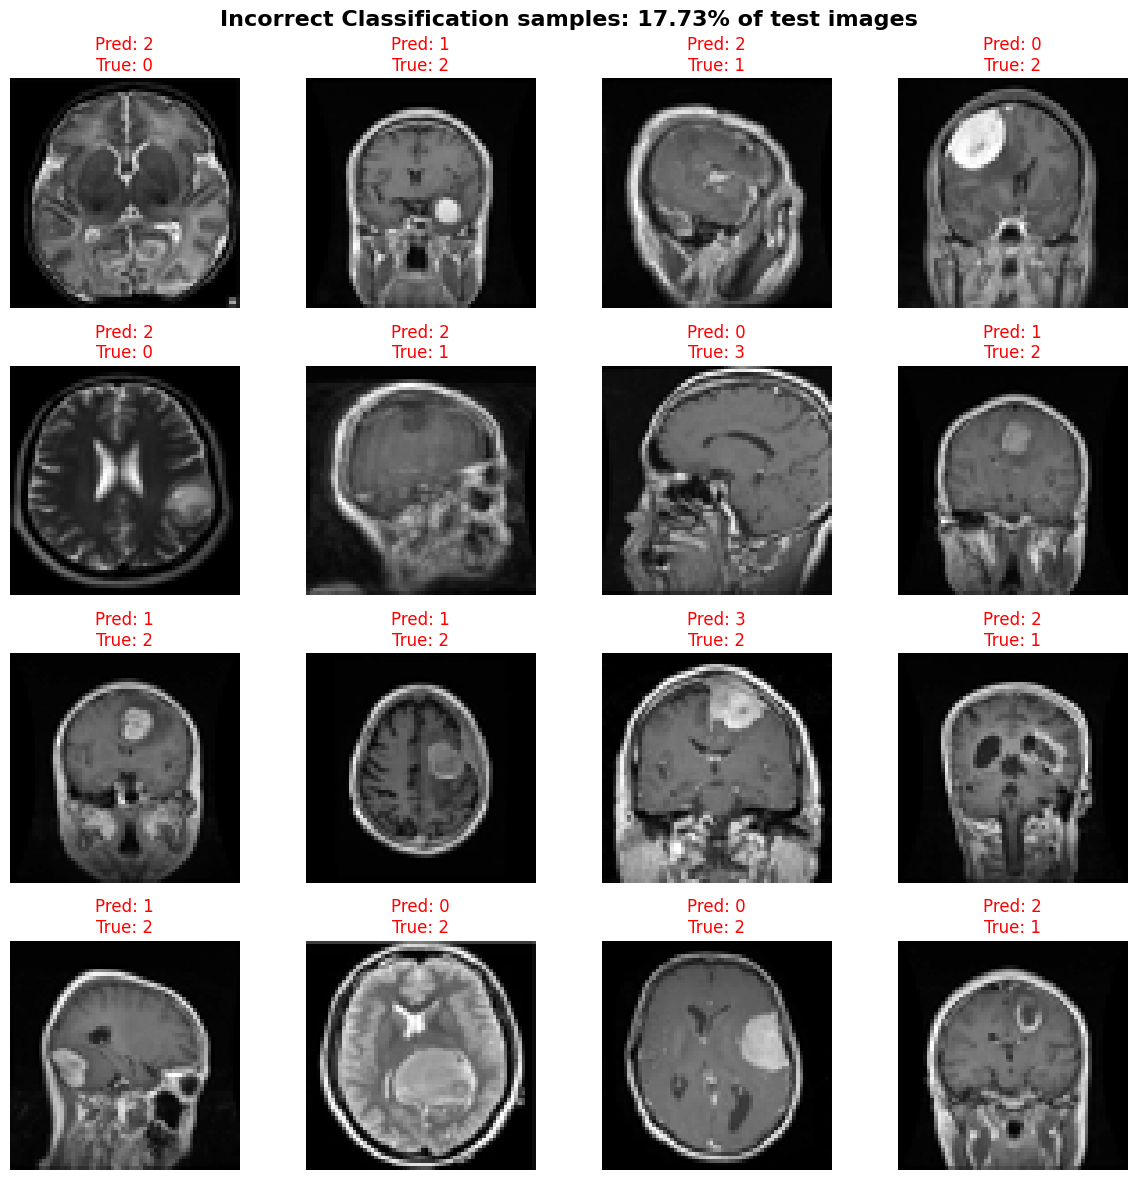

In [12]:
num_images = 16
misclassified = np.where(y_pred != ytest)
correct = np.where(y_pred == ytest)

plt.figure(figsize=(12, 12))
for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    plt.suptitle(f'Correct Classification samples: {cnn_acc * 100:.2f}% of test images', fontsize=16, fontweight='bold')
    img = xtest[i].reshape(64, 64)  
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {y_pred[correct[0][i]]}\nTrue: {ytest[correct[0][i]]}", 
              color='green' if y_pred[correct[0][i]] == ytest[correct[0][i]] else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()

print()
plt.figure(figsize=(12, 12))
for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    plt.suptitle(f'Incorrect Classification samples: {(1 - cnn_acc)*100:.2f}% of test images', fontsize=16, fontweight='bold')
    img = xtest[misclassified[0][i]].reshape(64, 64)  
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {y_pred[misclassified[0][i]]}\nTrue: {ytest[misclassified[0][i]]}", 
              color='green' if y_pred[misclassified[0][i]] == ytest[misclassified[0][i]] else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()


/Users/richardsoong/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/richardsoong/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


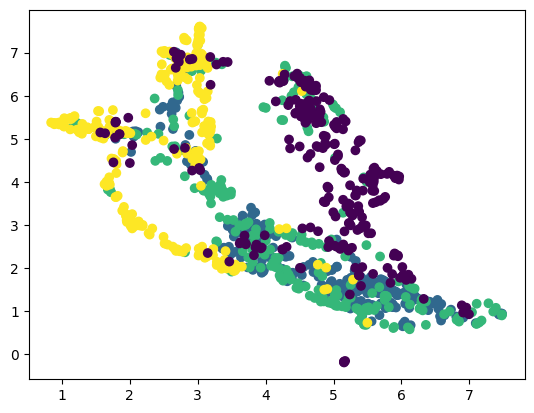

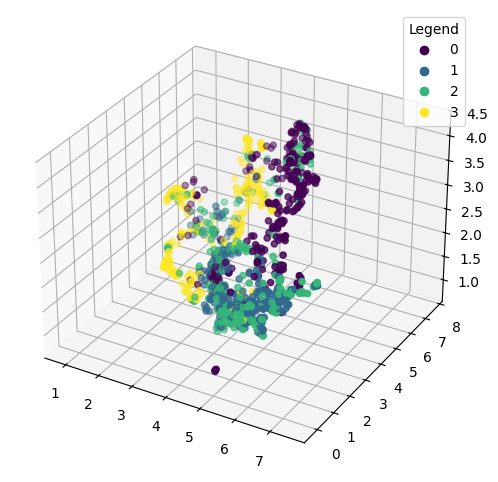

In [13]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=11, n_components=4)
x_umap = reducer.fit_transform(x.reshape((-1, 64*64)))


plt.scatter(x_umap[:, 0], x_umap[:, 1], c=y)
plt.plot()

# 3d scatterplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_umap[:, 0], x_umap[:, 1], x_umap[:, 2], c=y)
ax.legend(*scatter.legend_elements(), title='Legend')
plt.show()

(1100, 3)


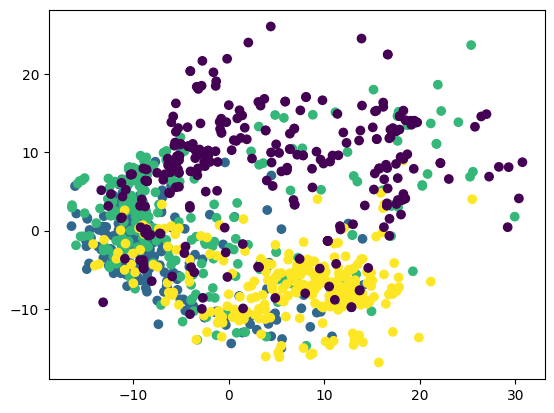

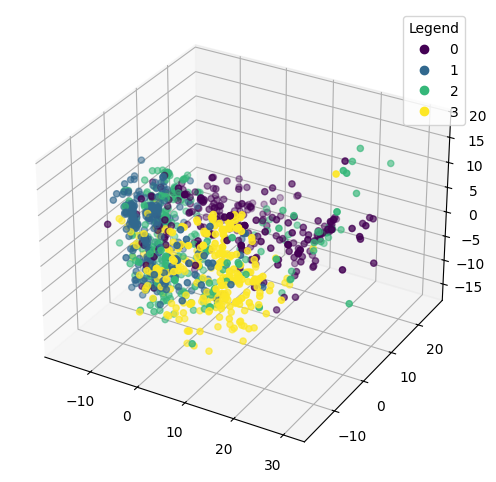

In [14]:
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D


isomap = Isomap(n_neighbors=14, n_components=3)
x_iso = isomap.fit_transform(x.reshape((-1, 64*64)))
print(x_iso.shape)

# 2d scatterplot
plt.scatter(x_iso[:, 0], x_iso[:, 1], c=y)
plt.plot()

# 3d scatterplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_iso[:, 0], x_iso[:, 1], x_iso[:, 2], c=y)
ax.legend(*scatter.legend_elements(), title='Legend')
plt.show()